In [13]:
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import random

print('Required version:')
print('     numpy  1.24.4')
print('     cv2 4.8.0')
print('     matplotlib 3.7.1')

print('Current version:')
print('     numpy ', np.__version__)
print('     cv2', cv.__version__)
print('     matplotlib', plt.matplotlib.__version__)

Required version:
     numpy  1.24.4
     cv2 4.8.0
     matplotlib 3.7.1
Current version:
     numpy  1.24.4
     cv2 4.8.0
     matplotlib 3.7.1


In [14]:
def k_n(des, k):
    row = len(des)
    col = len(des[0].des)

    dcp = np.zeros([row, col])
    for i in range(0, row):
        dcp[i, :] = des[i].des

    for j in range(0, row):
        diff = dcp - dcp[j]
        dis = np.sqrt(np.sum(diff * diff, axis=1))
        dis = np.matrix(dis)

        order = np.lexsort(dis)
        des[j].neighbour = order[0, 1:k + 1]

    return des


def sift_matrix(im, order):
    sift = cv.SIFT_create()
    im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    kp, d = sift.detectAndCompute(im, None)
    row = len(d)
    ps = []

    class KP:
        def __int__(self):
            self.seq = -1
            self.loc = []
            self.des = []
            self.neighbour = []

    for i in range(0, row):
        ps.append(KP())
        ps[i].seq = order
        ps[i].des = d[i]
        ps[i].loc = kp[i].pt

    return ps


def homography(points):
    if not points.any():
        raise ValueError('points is empty')
    row = len(points)
    n_mat = int(row / 2)
    mat = np.zeros([row, 9])

    for i in range(0, n_mat):
        x_h1, y_h1, x_h2, y_h2 = points[i][0], points[i][1], points[i + n_mat][0], points[i + n_mat][1]
        mat[2 * i][:] = [x_h1, y_h1, 1, 0, 0, 0, -x_h2 * x_h1, -x_h2 * y_h1, -x_h2]
        mat[2 * i + 1][:] = [0, 0, 0, x_h1, y_h1, 1, -y_h2 * x_h1, -y_h2 * y_h1, -y_h2]

    _, _, vt = np.linalg.svd(mat)
    H_res = vt[-1].reshape(3, 3)
    H_res = H_res / H_res[2, 2]

    return H_res


def ransac_h(k_1, k_2, matches, num_epochs):
    if not matches:
        raise ValueError('matches is empty')

    HH_res = []
    threshold = 1
    n_in = 0

    n_matches = len(matches)
    k1 = np.zeros([n_matches, 2])
    k2 = np.zeros([n_matches, 2])

    for i in range(n_matches):
        for j in range(2):
            k1[i, j] = k_1[matches[i].queryIdx].pt[j]
            k2[i, j] = k_2[matches[i].trainIdx].pt[j]

    mp = np.concatenate((k1, k2), axis=1)
    if not mp.any():
        raise ValueError('mp is empty')
    best_matched = []
    nums_points = 4

    def count_inliers(H, thresh, mp, matches):
        if not H.any():
            raise ValueError('H is empty')
        if not mp.any():
            raise ValueError('mp is empty')
        row = len(mp)
        p1 = mp[:, 0:2]
        p2 = mp[:, 2:4]

        x1 = np.concatenate((p1, np.ones([row, 1])), axis=1)
        x2 = np.dot(H, x1.T)
        # mask = x2[2, :] != 0  # mask for divide
        # x2[0:2, :] = np.divide(x2[0:2, :], x2[2, :], where=mask, out=np.zeros_like(x2[0:2, :]))
        epsilon = 1e-10  # avoid divide by zero
        x2[2, :] += epsilon  # add epsilon to avoid divide by zero
        x2[0:2, :] /= x2[2, :]  # divide by homogeneous coordinate

        # x2 = x2[0:2, :] / x2[2, :]
        es_p2 = x2[0:2, :].T
        if not es_p2.any():
            raise ValueError('es_p2 is empty')
        sub = p2 - es_p2
        sub_sq = sub * sub
        d = np.sqrt(np.sum(sub_sq, axis=1))
        # d = np.sqrt(sub_sq[:, 0] + sub_sq[:, 1])

        if not matches:
            raise ValueError('matches is empty')

        match = [m for d, m in zip(d, matches) if d < thresh]

        return match

    for i in range(0, num_epochs):
        samples = random.sample(range(0, n_matches), nums_points)
        points = np.array([[k1[samples[0]][0], k1[samples[0]][1]], [k1[samples[1]][0], k1[samples[1]][1]],
                           [k1[samples[2]][0], k1[samples[2]][1]], [k1[samples[3]][0], k1[samples[3]][1]],
                           [k2[samples[0]][0], k2[samples[0]][1]], [k2[samples[1]][0], k2[samples[1]][1]],
                           [k2[samples[2]][0], k2[samples[2]][1]], [k2[samples[3]][0], k2[samples[3]][1]]])

        H_res = homography(points)

        match = count_inliers(H_res, threshold, mp, matches)

        if len(match) > n_in:
            n_in = len(match)
            HH_res = H_res
            best_matched = match

    return HH_res, best_matched


def build_canvas(img1, img2, H_i):
    if not (len(img1.shape) == 3 and len(img2.shape) == 3):
        raise ValueError('im1 or im2 is not a RGB image')

    [r1_val, c1_val, _] = img1.shape
    [_, _, cc] = img2.shape

    # 
    def size_shape(H, h1):
        if not h1.any():
            raise ValueError("h1 is None")
        if len(h1.shape) == 2:
            [r_val, c_val] = h1.shape
            cc = 1
        else:
            [r_val, c_val, cc] = h1.shape

        [r_val, c_val, cc] = h1.shape
        lt, rt, lb, rb = np.array([[0, 0, 1]]), np.array([[0, c_val, 1]]), np.array([[r_val, 0, 1]]), np.array(
            [[r_val, c_val, 1]])
        if cc == 1:
            lt = lt.T
            rt = rt.T
            lb = lb.T
            rb = rb.T
        edge = np.concatenate((lt, rt, lb, rb), axis=0).T
        if cc == 1:
            edge = edge.T
        e_trans = np.dot(H, edge)
        e_trans = e_trans[0:2, :] / e_trans[2, :]
        return np.max(e_trans[0, :]), np.min(e_trans[0, :]), np.max(e_trans[1, :]), np.min(e_trans[1, :])

    [x_max, x_min, y_max, y_min] = size_shape(H_i, img2)

    sub = 1

    x_sub = int(np.min([0, x_min]) - sub)
    x_add = int(np.max([0, x_max - r1_val]) + sub)
    y_sub = int(np.min([0, y_min]) - sub)
    y_add = int(np.max([0, y_max - c1_val]) + sub)

    px_sub = np.zeros([-x_sub, c1_val, cc])
    px_add = np.zeros([x_add, c1_val, cc])

    if not (len(px_sub.shape) == 3 and len(px_add.shape) == 3):
        raise ValueError('add_x_minus or add_x_plus is not a RGB image')

    py_sub = np.zeros([-x_sub + r1_val + x_add, -y_sub, cc])
    py_add = np.zeros([-x_sub + r1_val + x_add, y_add, cc])
    # if not (len(py_sub.shape) == 3 and len(py_add.shape) == 3):
    #     raise ValueError('add_y_minus or add_y_plus is not a RGB image')
    cas = np.concatenate((px_sub, img1, px_add), axis=0)
    cas = np.concatenate((py_sub, cas, py_add), axis=1)

    return cas.astype(int), [x_sub, y_sub]


def trans_im22im1(comp, H_i, cas, im2):
    if not (len(cas.shape) == 3 and len(im2.shape) == 3):
        raise ValueError('canvas or im2 is not a RGB image')
    w = 0.618
    sps = 3
    [r_val, c_val, _] = im2.shape
    if not (len(comp) == 2):
        raise ValueError('compensation is not a 2D vector')
    for i in range(0, r_val * sps):
        for j in range(0, c_val * sps):
            pos = np.array([[i / sps, j / sps, 1]]).T
            trans_p = np.dot(H_i, pos)

            x1 = int(i / sps)
            y1 = int(j / sps)

            x2 = int(round(trans_p[0, 0] / trans_p[2, 0]) - comp[0])

            y2 = int(round(trans_p[1, 0] / trans_p[2, 0]) - comp[1])

            if np.any(cas[x2, y2] > 0):
                cas[x2, y2] = w * cas[x2, y2][:] + (1 - w) * im2[x1, y1][:]
            else:
                cas[x2, y2] = im2[x1, y1][:]

    return cas.astype(int)


def home_inliers(kp1, kp2, match_best):
    # change the inliers from tuple to list
    N = len(match_best)
    in1 = np.zeros([N, 2])
    in2 = np.zeros([N, 2])

    # Get the coordinate of keypoint
    for i in range(N):
        for j in range(2):
            in1[i] = [kp1[match_best[i].queryIdx].pt[1], kp1[match_best[i].queryIdx].pt[0]]
            in2[i] = [kp2[match_best[i].trainIdx].pt[1], kp2[match_best[i].trainIdx].pt[0]]

    # compare the Homography compute from the random points and the inliers
    in_points = np.concatenate((in1, in2), axis=0)
    H_best = homography(in_points)

    return H_best, in1, in2

In [15]:
class NS:

    def default_error(self):
        print("error")
        return [0, 0, 0, 0, 0]

    def pos_0(self):
        return [1, 0, 0, 0, 0]

    def pos_1(self):
        return [0, 1, 0, 0, 0]

    def pos_2(self):
        return [0, 0, 1, 0, 0]

    def pos_3(self):
        return [0, 0, 0, 1, 0]

    def pos_4(self):
        return [0, 0, 0, 0, 1]

    def switch(self, num):
        numbers = {
            1: self.pos_0,
            2: self.pos_1,
            3: self.pos_2,
            4: self.pos_3,
            5: self.pos_4
        }

        return numbers.get(num, self.default_error)()



In [16]:
def stitch_double(matched_points, time=2):
    if not matched_points.any():
        raise ValueError('matched_points is empty')

    def best_match_image(match_points):
        k = len(match_points)

        vote = np.zeros([k, 2])
        for i in range(k):
            vote[i] = [i + 1, np.argmax(match_points[i]) + 1]

        return vote

    if time == 1:

        vote = best_match_image(matched_points)
        l = len(vote)

        counter = np.zeros(l)
        for [j, k] in vote:
            counter[int(j - 1)] += 1
            counter[int(k - 1)] += 1

        # most popular image
        [m_order] = np.lexsort(np.matrix(counter))
        m_p1 = m_order[-1]
        #         print(m_order,m_p1)

        # find the image matches m_p and is second popular in all images
        im_p2 = -1
        for [j, k] in vote:
            if j == m_p1 + 1:
                [index] = np.where(m_order == k - 1)
                im_p2 = np.max(np.append(index, im_p2))
            elif k == m_p1 + 1:
                [index] = np.where(m_order == j - 1)
                # index is nparray, so the func can work must with below code 
                im_p2 = np.max(np.append(index, im_p2))

        m_p2 = m_order[im_p2]

    else:
        # 0 col is the matched points number
        [m_order] = np.lexsort(np.matrix(matched_points[:, 0]))
        #         print(m_order)
        m_p1 = 0
        m_p2 = m_order[-1]

    matches = [m_p1, m_p2]

    return matches


def sift_opera(i1, i2):
    if not i1.any() or not i2.any():
        raise ValueError('image is empty')

    if not (len(i1.shape) == 3):
        raise ValueError('image1 is not a RGB image')

    sift = cv.SIFT_create()

    i1 = cv.cvtColor(i1, cv.COLOR_BGR2GRAY)
    k1, dt1 = sift.detectAndCompute(i1, None)

    i2 = cv.cvtColor(i2, cv.COLOR_BGR2GRAY)
    k2, dt2 = sift.detectAndCompute(i2, None)

    if not dt2.any() or not dt1.any():
        raise ValueError('des1 or des2 is empty')

    def find_matches(d1, d2):
        if not (len(d1.shape) == 2):
            raise ValueError('des1 is not a matrix')
        if not (len(d2.shape) == 2):
            raise ValueError('des2 is not a matrix')
        [pd1, _] = d1.shape
        [pd2, _] = d2.shape

        m1 = []
        for i in range(0, pd1):
            dist = np.zeros([pd2, 1])
            for j in range(0, pd2):
                v = d1[i] - d2[j]
                dist[j] = np.dot(v, v.T)

            coords = np.argmin(dist)
            tp1 = int(dist[coords])
            m1.append(cv.DMatch(_imgIdx=0, _trainIdx=coords, _distance=tp1, _queryIdx=i))

        if not m1:
            raise ValueError('matches1 is empty')
        m2 = []
        for i in range(0, pd2):
            dist = np.zeros([pd1, 1])
            for j in range(0, pd1):
                v = d2[i] - d1[j]
                dist[j] = np.dot(v, v.T)

            coords = np.argmin(dist)
            tp1 = int(dist[coords])
            m2.append(cv.DMatch(_imgIdx=0, _trainIdx=coords, _distance=tp1, _queryIdx=i))

        if not m2:
            raise ValueError('matches2 is empty')

        matches = []
        for a in m1:
            for i in m2:
                if a.queryIdx == i.trainIdx and a.trainIdx == i.queryIdx:
                    matches.append(a)

        return matches

    matches = find_matches(dt1, dt2)
    if not matches:
        raise ValueError('matches is empty')
    min_matches = 8
    if len(matches) < min_matches:
        print('matches not enough')
        exit()
    return matches, k1, k2


def concat_imgs(im_1, im_2, img_1, img_2):
    if not im_1.any() or not im_2.any():
        raise ValueError('image is empty')

    [kpm, kp1, kp2] = sift_opera(im_1, im_2)

    while True:
        HH, match_best = ransac_h(kp1, kp2, kpm, 100000)

        if len(match_best) > 0:
            break

    H_best, _, _ = home_inliers(kp1, kp2, match_best)

    Hi = np.linalg.inv(H_best)

    canvas, compensation = build_canvas(img_1, img_2, Hi)

    img = trans_im22im1(compensation, Hi, canvas, img_2)
    img = img.astype(np.uint8)

    plt.figure(figsize=(20, 20))
    plt.imshow(img)

    im = cv.cvtColor(img, cv.COLOR_RGB2BGR)
    return im, img

In [17]:
# import the image
im1 = cv.imread('img/im01.jpg', cv.IMREAD_COLOR)
im2 = cv.imread('img/im02.jpg', cv.IMREAD_COLOR)
im3 = cv.imread('img/im03.jpg', cv.IMREAD_COLOR)
im4 = cv.imread('img/im04.jpg', cv.IMREAD_COLOR)
im5 = cv.imread('img/im05.jpg', cv.IMREAD_COLOR)
img1 = cv.cvtColor(im1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(im2, cv.COLOR_BGR2RGB)
img3 = cv.cvtColor(im3, cv.COLOR_BGR2RGB)
img4 = cv.cvtColor(im4, cv.COLOR_BGR2RGB)
img5 = cv.cvtColor(im5, cv.COLOR_BGR2RGB)

In [18]:
# show input image
input_images = np.hstack((im1, im2, im3, img4))
cv.imshow('First Four', input_images)
cv.imshow('Last', img5)
cv.waitKey(0)
cv.destroyAllWindows()
cv.waitKey(1)

-1

In [19]:
# concatenate image
im = []
img = []
im.append(im3)
im.append(im4)
im.append(im2)
im.append(im1)
im.append(im5)
img.append(img3)
img.append(img4)
img.append(img2)
img.append(img1)
img.append(img5)

# get all images SIFT keypoints
kp1 = sift_matrix(im[0], 1)
kp2 = sift_matrix(im[1], 2)
kp3 = sift_matrix(im[2], 3)
kp4 = sift_matrix(im[3], 4)
kp5 = sift_matrix(im[4], 5)

# concatenate keypoints
# print(len(kp1),len(kp2),len(kp3),len(kp4),len(kp5))
kp = kp1
kp[len(kp):len(kp)] = kp2
kp[len(kp):len(kp)] = kp3
kp[len(kp):len(kp)] = kp4
kp[len(kp):len(kp)] = kp5
# print(len(kp))

# find the k nears neighbours
k = 5
kp = k_n(kp, 5)

# for every image count the matching point in all images
m_points = np.zeros([6, 5])  # matched points number

ns = NS()
for p in kp:
    im_num = p.seq
    for near in p.neighbour:
        near_num = ns.switch(kp[near].seq)
        m_points[im_num] = m_points[im_num] + near_num

# cut the 0 row 
m_points = m_points[1:]

# count the most matched
# remove the self matched points

### Handling unordered images

[2, 0]
[[2137.    0.  524.  707.]
 [2684.  477.    0.  639.]
 [2143.  980. 1029.    0.]]
[0, 0]
[[2684.  477.    0.  639.]
 [2143.  980. 1029.    0.]]
[0, 0]
[[2143.  980. 1029.    0.]]
[0, 0]
[]


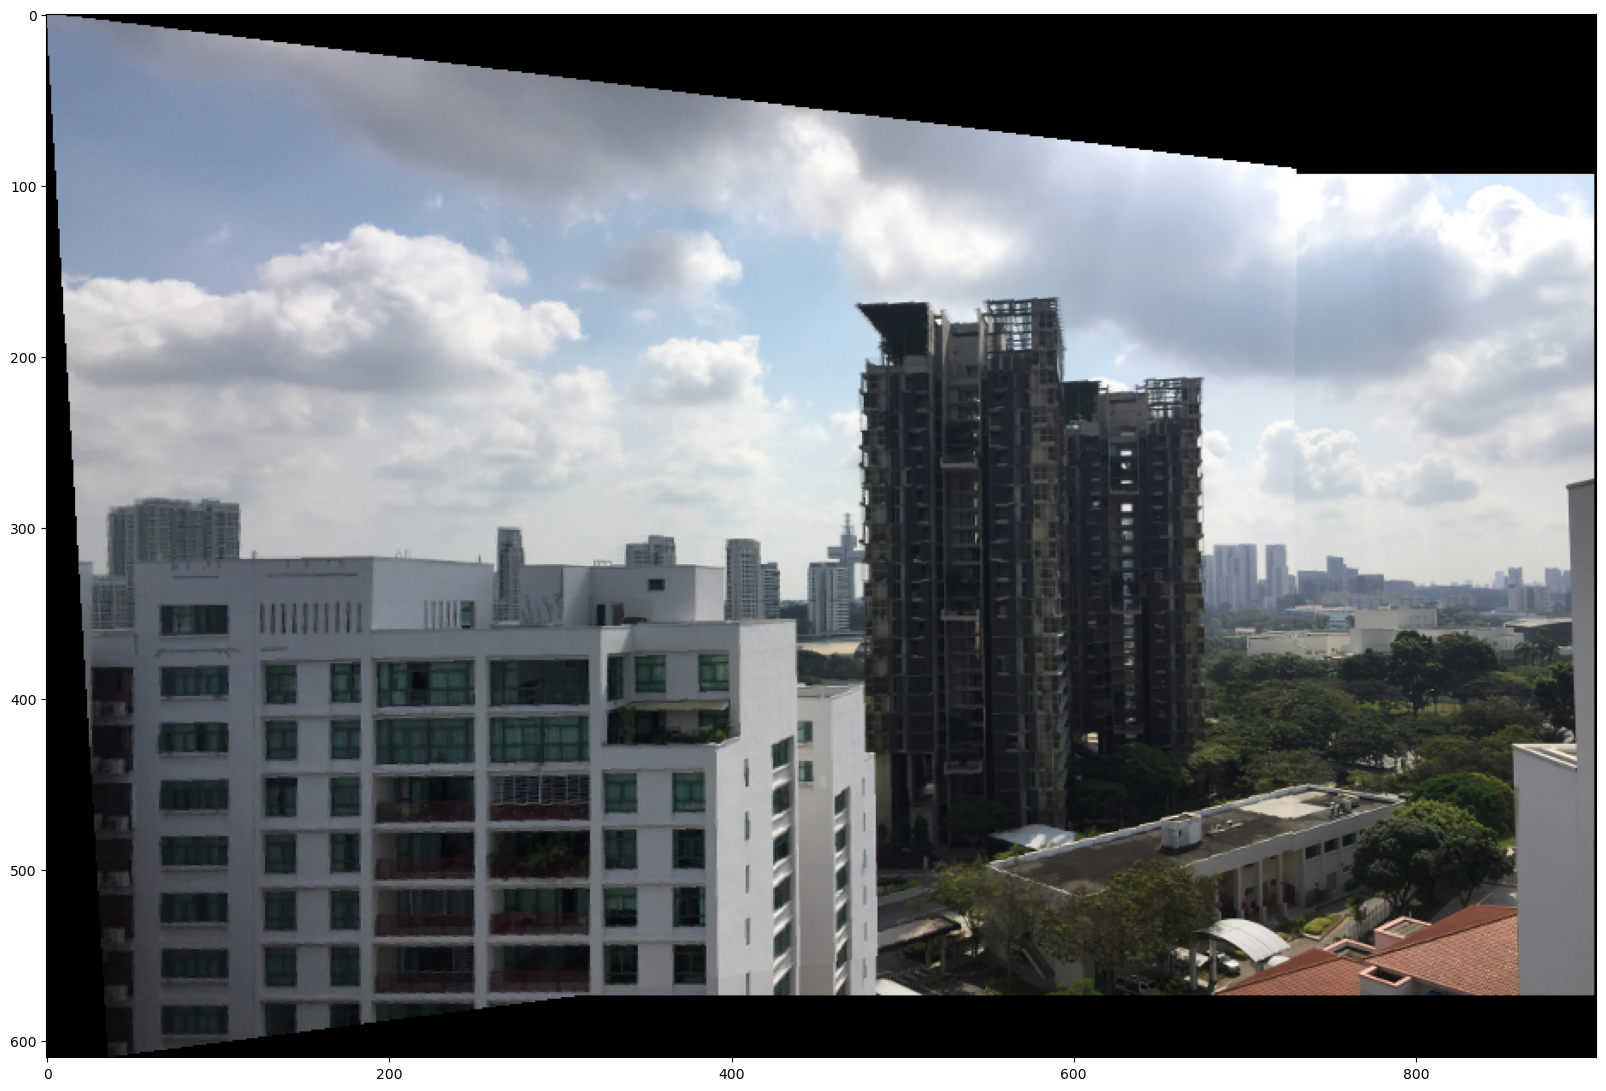

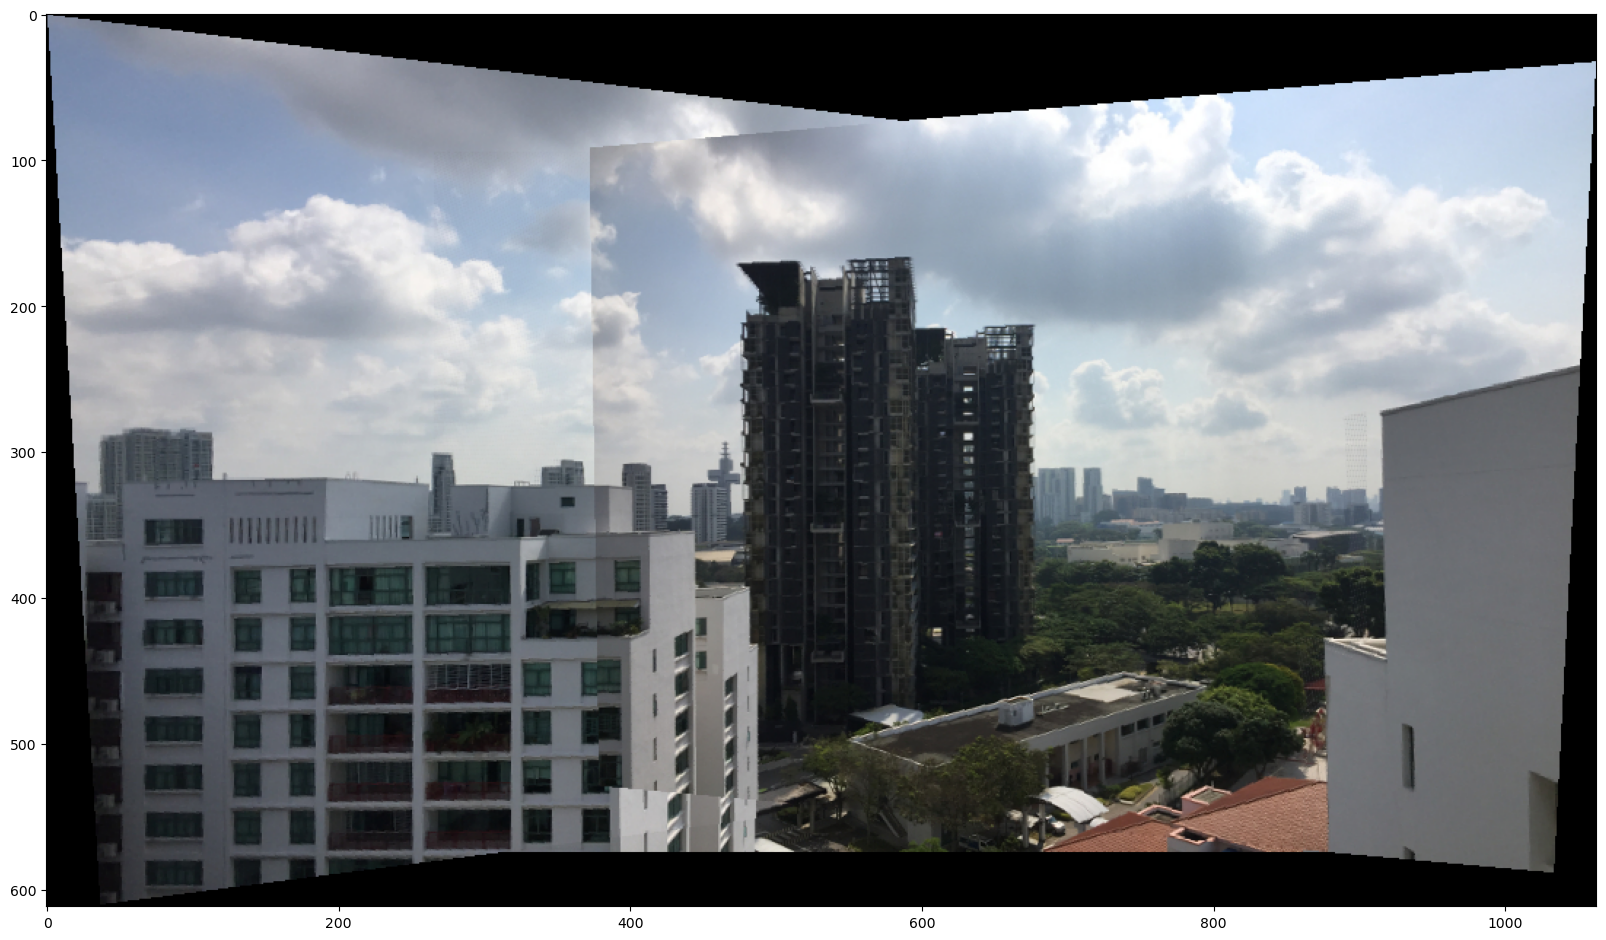

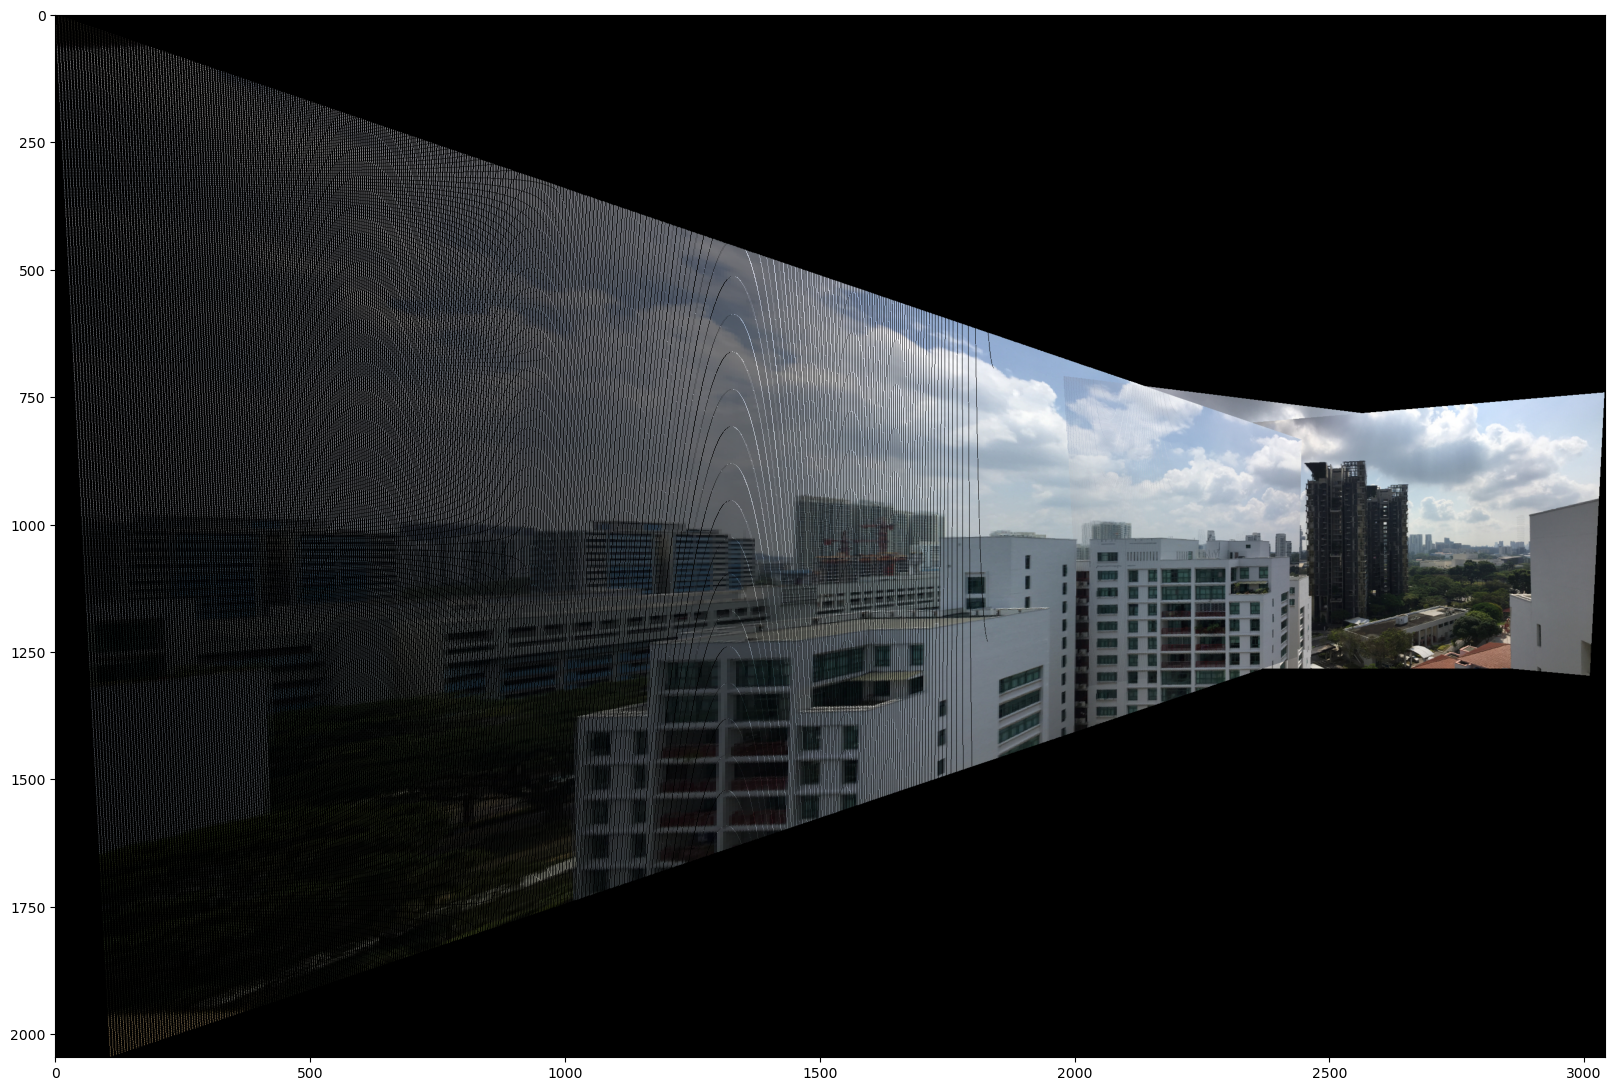

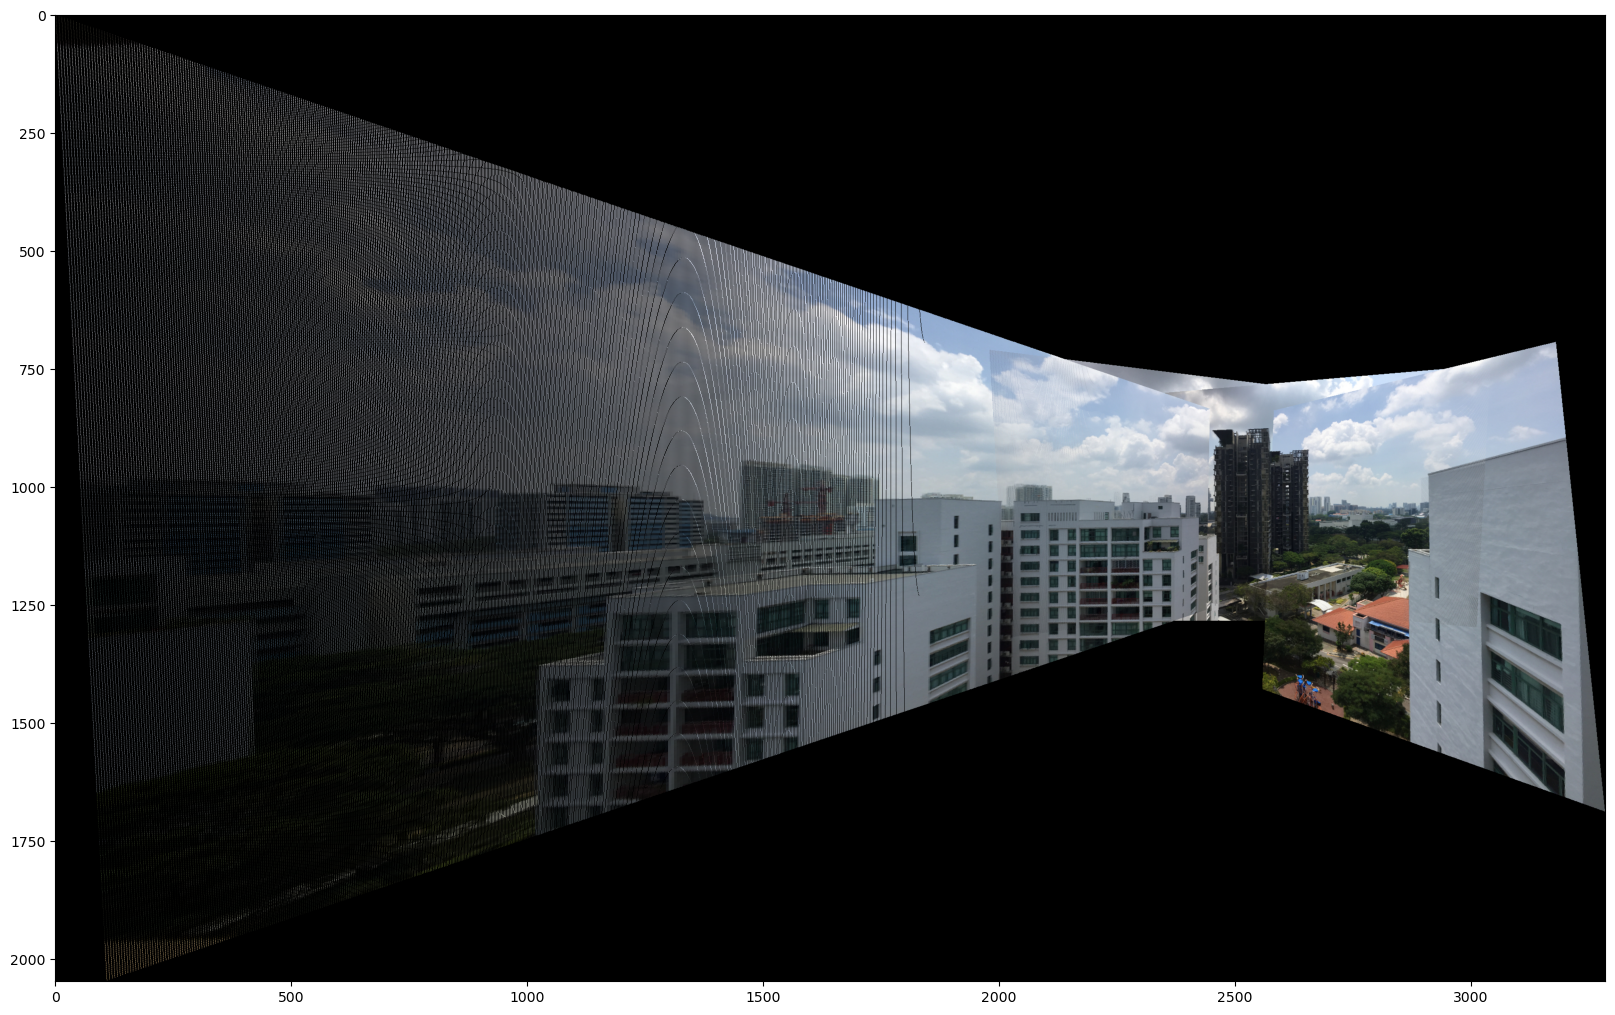

In [20]:
m_p = m_points - m_points * np.identity(k)
# 1st stitching
match = stitch_double(m_p, 1)
[output_im, output_img] = concat_imgs(im[match[1]], im[match[0]], img[match[1]], img[match[0]])

# delete matches lines in m_p
m_p = np.delete(m_p, match, axis=0)
summ = m_p[:, match[0]] + m_p[:, match[1]]
summ = np.matrix(summ).T
m_p = np.delete(m_p, match, axis=1)
m_p = np.concatenate((summ, m_p), axis=1)
print(match)
print(m_p)
# delete stitched image
del im[match[0]]
del im[match[1]]
del img[match[0]]
del img[match[1]]

for i in range(2, 5):
    match = stitch_double(m_p, i)
    [output_im, output_img] = concat_imgs(output_im, im[match[1]], output_img, img[match[1]])
    # delete matches lines in m_p

    m_p = np.delete(m_p, match, axis=0)
    summ = m_p[:, match[0]]

    # summ = np.matrix(summ).T
    m_p = np.delete(m_p, match[1], axis=1)
    m_p = np.concatenate((summ, m_p), axis=1)
    print(match)
    print(m_p)
    del im[match[1]]
    del img[match[1]]


In [21]:
# # 2nd stitching
# match = num_stitch(m_p, 2)
# [output_im, output_img] = concat_imgs(output_im, im[match[1]], output_img, img[match[0]])

In [22]:
def interpolation(image, size):
    if not image.any():
        raise ValueError('image is empty')
    # check if RGB image
    if not (len(image.shape) == 3):
        raise ValueError('image is not a RGB image')
    [row, col, c] = image.shape
    valid_pixels = image[~np.isnan(image)]  # catch the valid pixels
    default_val = int(np.mean(valid_pixels)) if valid_pixels.size else 0  # compute the mean of valid pixels
    for j in range(0, row):
        for k in range(0, col):
            if np.all(np.isnan(image[j, k]) | (image[j, k] == 0)):  # check if NaN or 0
                for n in range(0, c):
                    r_start, r_end = max(j - size, 0), min(j + size + 1, row)
                    c_start, c_end = max(k - size, 0), min(k + size + 1, col)

                    sub_array = image[r_start:r_end, c_start:c_end, n]
                    avg_val = np.nanmean(sub_array)  # use np.nanmean to ignore NaN values

                    if np.isnan(avg_val):  # if NaN，use default value
                        avg_val = default_val

                    image[j, k, n] = int(avg_val)

    return image

### remove the black area

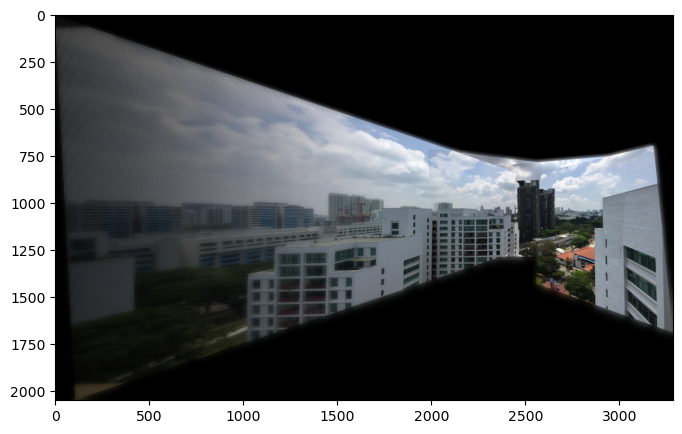

In [23]:
out_correct = interpolation(output_img, 10)
# out_correct = out_correct.astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.imshow(out_correct)

1. 处理无序的图像
参考文献：论文1（使用不变特征的自动全景图像拼接）

当捕获多个图像以进行全景拼接时，这些图像可能是无序的。处理这样的无序图像是一个挑战，因为传统的全景软件可能期望图像以一定的顺序（从左到右或从右到左）。

解决方案：
该论文建议使用不变特征自动识别图像对之间的重叠区域，而不考虑它们的初始顺序。不变特征在缩放、旋转和其他变换下保持一致。如SIFT（尺度不变特征变换）或SURF（加速鲁棒特征）算法可以用于此目的。通过匹配这些特征，可以确定图像的正确顺序。

2. 错误累积问题 & 包裹调整
参考文献：论文1

当拼接多个图像时，图像对之间的小型注册错误可能会累积，导致最终全景图像的错位。

解决方案：
包裹调整是一种流行的方法，用于最小化这种累积错误。它是一种联合优化技术，其中摄像机位置和场景中的3D点都被迭代地调整，以减少再投影误差。同时考虑整套图像，并同时优化摄像机参数和场景几何形状，以获得全局一致的解决方案。

3. 扭曲、直线化、增益补偿 & 多带混合
参考文献：论文1

扭曲：从不同视点捕获的图像需要转换到一个共同的视点以进行无缝拼接。这种转换称为扭曲。通常使用圆柱或球面投影进行此操作。
直线化：扭曲后，全景可能具有弯曲的地平线，特别是如果输入图像没有完美对齐。直线化算法调整图像以展平地平线并消除任何不想要的曲率。
增益补偿：连续拍摄之间的曝光差异可能导致拼接全景中可见的接缝。增益补偿旨在调整图像的亮度和对比度，以确保全景中的一致性。
多带混合：这种技术在频率域而不是空间域中混合图像。图像被分解成不同的频率带，每个带分别混合。这确保了平滑的过渡，特别是在具有详细纹理或锐利边缘的区域。
4. 视差问题
参考文献：论文2（耐视差的图像拼接）

视差是从不同的视点观察到的物体位置的明显移动。在图像拼接的背景下，由于与摄像机接近的功能与距离摄像机较远的功能不同，视差可能导致错位。

解决方案：
该论文提出了各种技术，包括尽可能的投影扭曲和保持内容的扭曲。这些技术调整图像的变换，以减少视差的可见效果。

In [24]:
# # 1. 读取图片
# img = output_img
# height, width = img.shape[:2]
# 
# # 2. 定义源点和目标点
# src_pts = np.array([
#     [0, 0],
#     [width - 1, 0],
#     [width - 1, height - 1],
#     [0, height - 1]
# ], dtype=np.float32)
# 
# # 目标点可以根据实际的变换情况进行调整
# dst_pts = np.array([
#     [width*0.2, height*0.2],
#     [width*0.8, height*0.2],
#     [width*0.8, height*0.8],
#     [width*0.2, height*0.8]
# ], dtype=np.float32)
# 
# # 3. 获取透视变换矩阵
# M = cv.getPerspectiveTransform(src_pts, dst_pts)
# 
# # 4. 使用warpPerspective进行变换
# warped_img = cv.warpPerspective(img, M, (width, height))
# 
# # 5. 保存结果
# plt.imshow(warped_img)
